### Import libraries

In [2]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [3]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [4]:
from util import *
%load_ext autoreload
%autoreload 2

In [5]:
set_gpu_limit(6)

### Import data for regular NN without categorical embedding

In [6]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.1,random_state=2020)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,test_size=0.11,random_state=2020)

### Garbage collect

In [7]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Set up base parameter for a base regression model

In [8]:
BATCH_SIZE = 256 
input_size = features.shape[1]
MAX_EPOCH = 1000
lr = 1e-3
l2 = 0 
SIZES = [512,512]
METRICS = ["MAPE","MAE"]

### Set up a few common parameter and make tensorflow dataset

* notice: this dataset has pretty similar scale so no reason to normalize to help with gradient descent

In [9]:
train, dev = make_tensor_dataset(X_train,y_train,256), make_tensor_dataset(X_dev,y_dev,256)

### Set up base parameter for a base regression model

In [9]:
base_model = make_model(SIZES,input_size,METRICS,l2,lr)

In [10]:
base_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               105984    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 369,153
Trainable params: 369,153
Non-trainable params: 0
_________________________________________________________________


### Define early stop

In [11]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

In [ ]:
# history = base_model.fit(train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=dev,
#                          callbacks=[earlystop])

In [ ]:
# base_model.save("base_nn_regression_mdl.h5")

In [12]:
base_model = tfk.models.load_model("base_nn_regression_mdl.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [16]:
# plot_metrics(history,"loss")

In [ ]:
# plot_metrics(history,"MAPE")

### Check base model result

In [13]:
base_model.evaluate(X_test.values,y_test.values,batch_size=BATCH_SIZE)

39/39 [==============================] - 0s 1ms/step - loss: 5860600.5000 - mean_absolute_percentage_error: 10.2301 - mean_absolute_error: 1548.1078


[5860600.5, 10.230082511901855, 1548.1077880859375]

In [14]:
regression_metrics(base_model,X_train.values,y_train,X_test.values,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.943976,2334.725640,898.469871
test,0.937015,2420.867492,1159.450571


### Check price vs predicted value

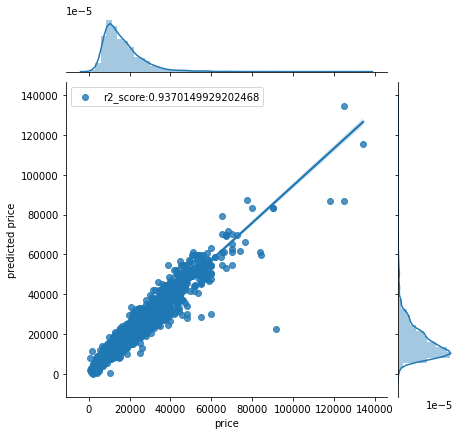

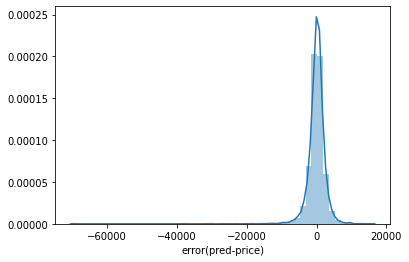

In [36]:
plot_pred_price(base_model,X_test.values,y_test,batch_size=BATCH_SIZE)

### Pretty decent results and the error appear to be normal distribution

#### Definitely can benefit from tuning. 

In [37]:
bigger_model = make_model([2056,2014,512,512],input_size,METRICS,1e-4,lr)

In [38]:
bigger_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2056)              425592    
_________________________________________________________________
dense_4 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1031680   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 5,863,239
Trainable params: 5,863,239
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# history_2 = bigger_model.fit(train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=dev,
#                          callbacks=[earlystop])

In [ ]:
# bigger_model.save("bigger_model_nn.h5")

In [10]:
bigger_model = tfk.models.load_model("bigger_model_nn.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [40]:
regression_metrics(bigger_model,X_train.values,y_train,X_test.values,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.947901,2251.459161,771.684800
test,0.938210,2397.796630,515.268254


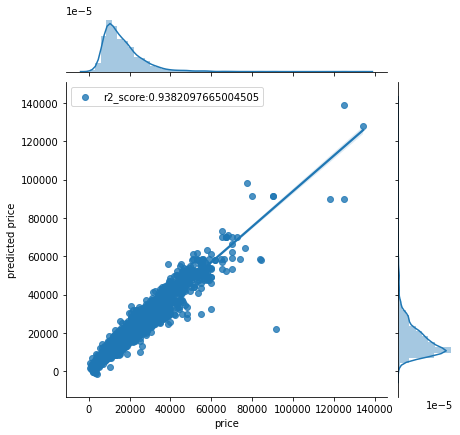

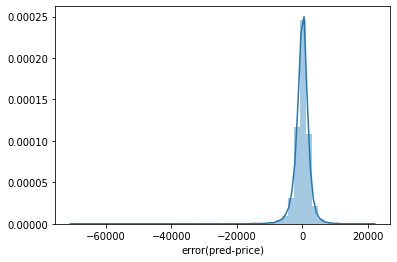

In [42]:
plot_pred_price(bigger_model,X_test.values,y_test,256)

### Pretty decent result and not over training the train data either

In [23]:
bigger_model_2 = make_model([2056,2014,512,512],input_size,METRICS,1e-4,5e-5)

In [26]:
# history_2 = bigger_model_2.fit(train, epochs=MAX_EPOCH,shuffle=True,
#                          verbose = 1, validation_data=dev,
#                          callbacks=[earlystop])

Epoch 1/1000
311/311 [==============================] - 1s 4ms/step - loss: 226725296.0000 - MAPE: 70.6021 - MAE: 11414.6680 - val_loss: 90594080.0000 - val_MAPE: 48.1973 - val_MAE: 6497.3301
Epoch 2/1000
311/311 [==============================] - 1s 4ms/step - loss: 54850036.0000 - MAPE: 34.5587 - MAE: 4802.0396 - val_loss: 36151400.0000 - val_MAPE: 21.8560 - val_MAE: 3464.3315
Epoch 3/1000
311/311 [==============================] - 1s 4ms/step - loss: 26535758.0000 - MAPE: 20.1148 - MAE: 3153.9172 - val_loss: 27528064.0000 - val_MAPE: 18.8729 - val_MAE: 3000.1492
Epoch 4/1000
311/311 [==============================] - 1s 4ms/step - loss: 20960424.0000 - MAPE: 18.0187 - MAE: 2802.3606 - val_loss: 23638520.0000 - val_MAPE: 17.3038 - val_MAE: 2751.0171
Epoch 5/1000
311/311 [==============================] - 1s 4ms/step - loss: 18115302.0000 - MAPE: 16.8210 - MAE: 2596.2922 - val_loss: 21328802.0000 - val_MAPE: 16.2859 - val_MAE: 2594.0388
Epoch 6/1000
311/311 [==========================

311/311 [==============================] - 1s 4ms/step - loss: 5669545.0000 - MAPE: 9.8731 - MAE: 1531.6514 - val_loss: 8560518.0000 - val_MAPE: 10.0808 - val_MAE: 1626.4806
Epoch 88/1000
311/311 [==============================] - 1s 3ms/step - loss: 5663000.5000 - MAPE: 9.8809 - MAE: 1532.9290 - val_loss: 8571597.0000 - val_MAPE: 9.9412 - val_MAE: 1625.0104
Epoch 89/1000
311/311 [==============================] - 1s 4ms/step - loss: 5654260.0000 - MAPE: 9.8784 - MAE: 1532.2981 - val_loss: 8519572.0000 - val_MAPE: 9.9619 - val_MAE: 1617.5585
Epoch 90/1000
311/311 [==============================] - 1s 4ms/step - loss: 5626422.0000 - MAPE: 9.8691 - MAE: 1529.1700 - val_loss: 8476436.0000 - val_MAPE: 10.0190 - val_MAE: 1615.8660
Epoch 91/1000
311/311 [==============================] - 1s 4ms/step - loss: 5602161.5000 - MAPE: 9.8434 - MAE: 1527.0750 - val_loss: 8514585.0000 - val_MAPE: 9.9262 - val_MAE: 1616.6920
Epoch 92/1000
311/311 [==============================] - 1s 4ms/step - loss: 

In [27]:
# bigger_model_2.save("bigger_model_2.h5")

In [11]:
bigger_model_2 = tfk.models.load_model("bigger_model_2.h5",custom_objects={"leaky_relu":tf.nn.leaky_relu})

In [45]:
regression_metrics(bigger_model_2,X_train.values,y_train,X_test.values,y_test,256)

,r2_score,rmse,price_diff_abs_max
train,0.948620,2235.873711,816.022391
test,0.939284,2376.859028,582.943434


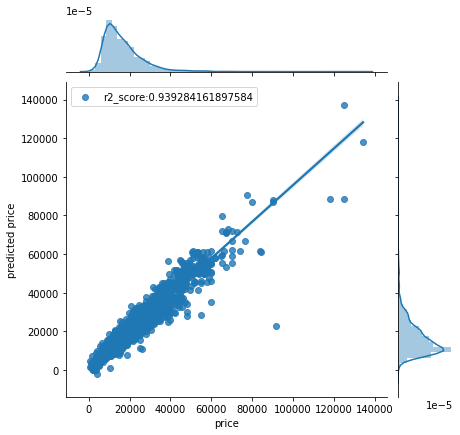

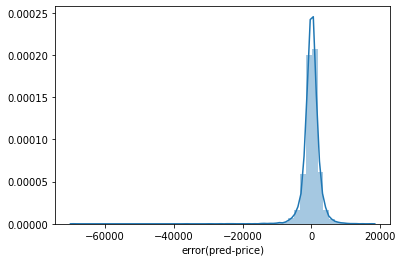

In [46]:
plot_pred_price(bigger_model_2,X_test.values,y_test,256)

### Since we have limited data, having bigger NN didn't seem to help with the improvement

---

### Looking at special cases of why the model has hard time predicting certain car price

In [47]:
price_table = price_diff(bigger_model,features,y,batch_size=256)

In [48]:
price_table.sort_values("price_diff_abs",ascending=False).head(20)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,...,model_EcoSport,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct,price_diff_abs
11984,1,0,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-771.684800,771.684800
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-722.626006,722.626006
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-593.055130,593.055130
39978,1,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-515.268254,515.268254
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-422.928905,422.928905
47201,1,5,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-409.967556,409.967556
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-407.544633,407.544633
44539,1,4,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-391.214094,391.214094
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,-350.905927,350.905927
40171,1,4,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-278.709283,278.709283


### Most of these models are older. The top cases have a weird combination of low car mileage but older year model 

### Let's extract model weights and perform weight matrix multiplication to estimate feature importance

In [131]:
estimated_coefs_base = coeff_estimation(base_model,3)

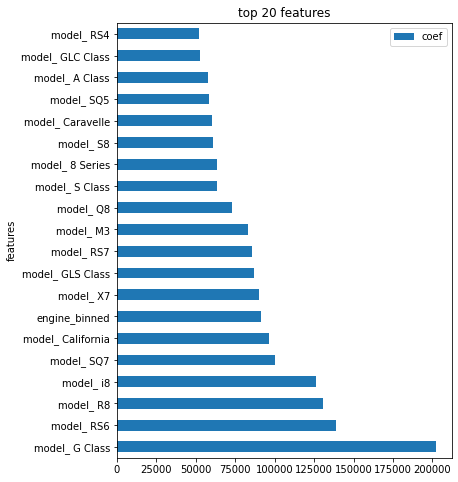

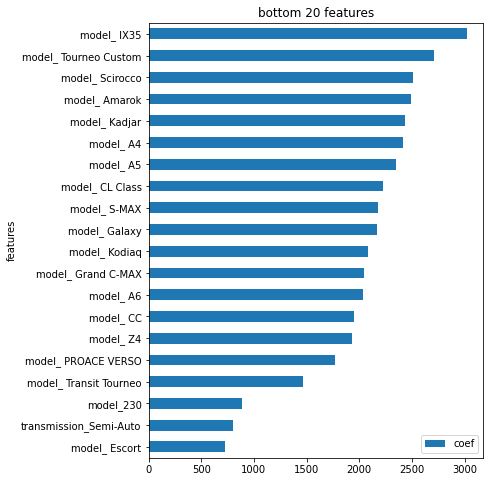

,features,score
67,model_ G Class,202152.031250
132,model_ RS6,138971.500000
127,model_ R8,130343.640625
193,model_ i8,126337.992188
146,model_ SQ7,100036.359375
...,...,...
116,model_ PROACE VERSO,1772.428711
166,model_ Transit Tourneo,1469.430664
197,model_230,889.876343
201,transmission_Semi-Auto,800.031311


In [144]:
linear_feature_importance(X_test.columns,base_model,NN_weights=estimated_coefs_base.flatten())

In [13]:
estimated_coefs_bigger = coeff_estimation(bigger_model,5)

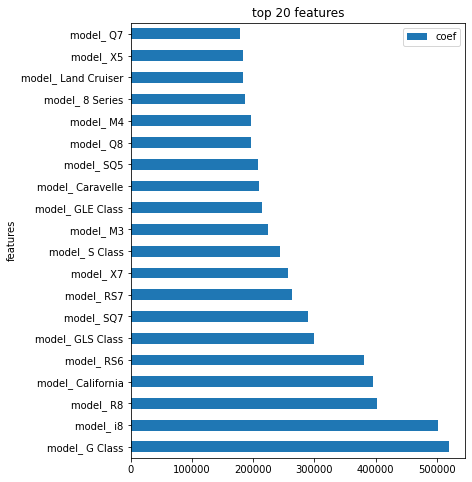

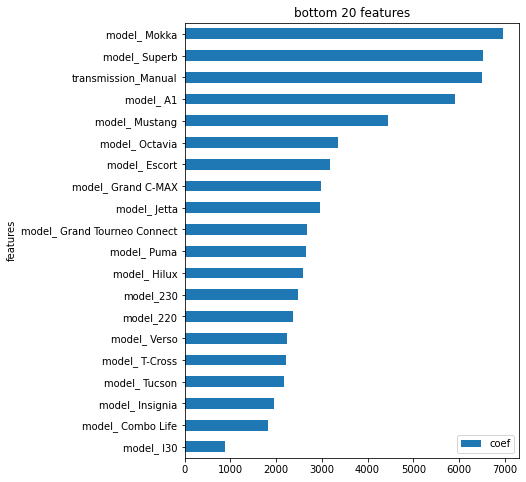

,features,score
67,model_ G Class,520545.250000
193,model_ i8,501177.812500
127,model_ R8,401965.687500
48,model_ California,395940.937500
132,model_ RS6,380847.687500
...,...,...
155,model_ T-Cross,2208.675293
167,model_ Tucson,2175.201172
92,model_ Insignia,1956.674072
53,model_ Combo Life,1822.669800


In [15]:
linear_feature_importance(X_test.columns,bigger_model,NN_weights=estimated_coefs_bigger.flatten())

In [16]:
estimated_coefs_bigger_2 = coeff_estimation(bigger_model_2,5)

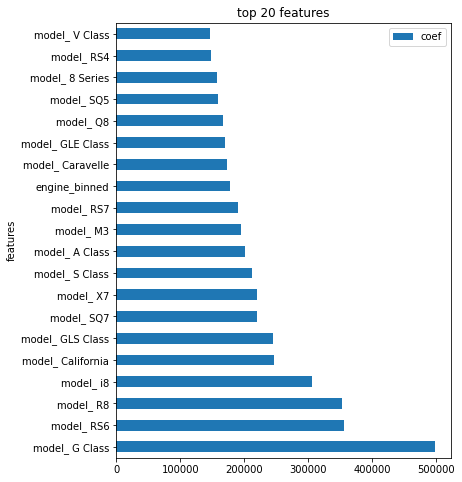

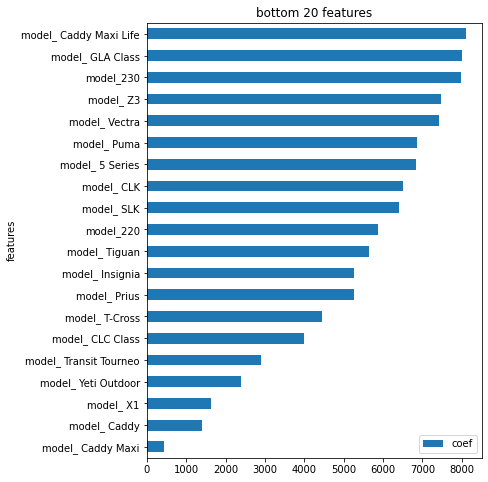

,features,score
67,model_ G Class,498513.562500
132,model_ RS6,355744.062500
127,model_ R8,353228.062500
193,model_ i8,306533.687500
48,model_ California,246594.937500
...,...,...
166,model_ Transit Tourneo,2910.931885
187,model_ Yeti Outdoor,2391.718506
178,model_ X1,1625.631104
44,model_ Caddy,1404.513184


In [17]:
linear_feature_importance(X_test.columns,bigger_model,NN_weights=estimated_coefs_bigger_2.flatten())

### The bigger models have all model type as top features. 

### You see some overlapping features between NN models and other methods.

____